<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Getting Started with QISKit*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Ismael Faro, Andrew Cross, Ali Javadi

## QISKit (Quantum Information Software developer Kit)

This tutorial aims to explain how to use QISKit. We assume you have installed QISKit if not please look at [qiskit.org](http://www.qiskit.org) or the install [documentation](https://github.com/QISKit/qiskit-tutorial/blob/master/INSTALL.md). 

QISKit is a Python software development kit that you can use to create your quantum computing programs based on circuits defined through the [OpenQASM](https://github.com/QISKit/qiskit-openqasm) specification and execute them on several backends (real quantum processors online, simulators online, and simulators on local). For the online backends conects to the [IBM Q Experience project](http://quantumexperience.ng.bluemix.net/).

In addition to this tutorial, we have other tutorials that introduce you to more complex concepts directly related to quantum computing.

More examples:
- Familiarize yourself with the important concepts of [superposition and entanglement](../qis/superposition_and_entanglement.ipynb).

In [1]:
import sys
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import QuantumProgram
from qiskit.backends import discover_local_backends, discover_remote_backends

## Basic Concept

The basic concept of our QISKit core is an array of quantum circuits. The workflow consists of three stages: [Build](#sectionB), [Compile](#sectionC), and [Run](#sectionR). Build allows you to make different quantum circuits that represent the problem you are solving; Compile allows you to rewrite them to run on different backends (simulators/real chips of different [quantum volumes](http://ibm.biz/qiskit-quantum-volume), sizes, fidelity, etc); and Run launches the jobs.  After the jobs have been run, the data is collected. There are methods for putting this data together, depending on the program. This either gives you the answer you wanted, or allows you to make a better program for the next instance.

### Building your circuit: Create it  <a id='sectionB'></a>

The basic elements needed for your first program are the QuantumCircuit, QuantumRegister, and ClassicalRegister.

In [3]:
# Create a Quantum Register called "q" with 3 qubits
qr = QuantumRegister("q", 3)

# Create a Classical Register called "c" with 3 bits
cr = ClassicalRegister("c", 3)

# Create a Quantum Circuit called involving "qr" and "cr"
circuit = QuantumCircuit(qr, cr)

After you create the circuit with its registers, you can add gates to manipulate the registers. As you proceed though the tutorial you will find more quantum gates and circuits but the below is an example of the quantum half adder.

In [4]:
# Not gate on qubit 0
circuit.x(qr[0])

# Not gate on qubit 1
circuit.x(qr[1])

# Barrier to seperator the input from the circuit
circuit.barrier(qr[0])
circuit.barrier(qr[1])
circuit.barrier(qr[2])

# Toffoli gate from qubit 0,1 to qubit 2
circuit.ccx(qr[0], qr[1], qr[2])

# CNOT (Controlled-NOT) gate from qubit 0 to qubit 1
circuit.cx(qr[0], qr[1])

# measure gate from qr to cr
circuit.measure(qr, cr)

### Extract OpenQASM

You can obtain a OpenQASM representation of your code.

In [5]:
# QASM from a program

QASM_source = circuit.qasm()

print(QASM_source)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
x q[0];
x q[1];
barrier q[0];
barrier q[1];
barrier q[2];
ccx q[0],q[1],q[2];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];



### Visualize Circuit

You can visualize your circuit using QISKit's `circuit_drawer`, which plots the unrolled circuit in the specified basis.

NOTE: To get this to work you need to make sure poppler is installed.

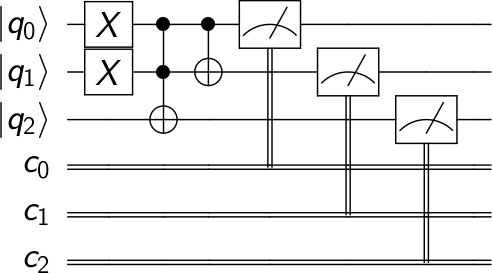

In [6]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuit)

### Execute <a id='sectionC'></a>

First we need to choose the backend. Lets start with the local simulator 

In [7]:
backend = 'local_qasm_simulator' 
circuits = ['Circuit']  # Group of circuits to execute

Next we need to run the circuit

In [8]:
# Create a Quantum Program for execution 
qp = QuantumProgram()
# Add the circuit you created to it, and call it the "bell" circuit.
# (You can add multiple circuits to the same program, for batch execution)
qp.add_circuit("Circuit", circuit)
result = qp.execute(circuits, backend, wait=2, timeout=240)
print(result)

COMPLETED


When you run a program, the result will be a new object that contains the data. The status of the results can be obtained using print and will one of the follow:

```
JOB_STATUS = {
    inProgress: 'RUNNING',
    errorOnCreate: 'ERROR_CREATING_JOB',
    errorExecuting: 'ERROR_RUNNING_JOB',
    completed: 'COMPLETED'
  };
``` 

#### Execute Parameters 
Execute has the combined parameters of compile and run.

```qp.execute(name_of_circuits=None, backend='local_qasm_simulator', config=None, wait=5, timeout=60, basis_gates=None, coupling_map=None, initial_layout=None, shots=1024, max_credits=3, seed=None, hpc=None)
```

(**Tip**: You can obtain the above parameters in Jupyter. Simply place the text cursor on a function and press Shift+Tab)

### Result
You can access the result via the function 

```get_counts('name')```. 

In [9]:
result.get_counts('Circuit')

{'101': 1024}

### Execute on a Real Device<a id='sectionR'></a>

In [10]:
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

In [11]:
def lowest_pending_jobs(api):
    """Returns the backend with lowest pending jobs."""
    remote_backends = discover_remote_backends(api)
    remote_backends.remove('ibmqx_hpc_qasm_simulator')
    remote_backends.remove('ibmqx_qasm_simulator')
    device_status = [api.backend_status(backend) for backend in remote_backends]

    best = min([x for x in device_status if x['available'] is True],
               key=lambda x: x['pending_jobs'])
    return best['backend'] 

In [12]:
backend = lowest_pending_jobs(api)
print("the best backend is " + backend)

the best backend is ibmqx4


In [13]:
circuits = ['Circuit']   # Group of circuits to execute
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3          # Maximum number of credits to spend on executions. 

result_real = qp.execute(circuits, backend=backend, shots=shots, max_credits=max_credits, wait=10, timeout=240)

Like before, the counts from the execution can be obtained using ```get_counts('name')``` 

In [14]:
result_real.get_counts('Circuit')

{'00000': 47,
 '00001': 103,
 '00010': 105,
 '00011': 49,
 '00100': 109,
 '00101': 508,
 '00110': 69,
 '00111': 34}

Here we see that real device gives more outcomes than the simulation as the experiment has noise. This circuit is rather complicated to implement on real hardware as it uses a CCX (Toffoli) gate and as such the effect of noise is large. Nevertheless the highest outcome is the same as the ideal prediction. 

In [15]:
%run "../../version.ipynb"

Package,Version
QISKit,0.4.10
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
